# Case with one risky Asset

# 1. Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# 2. Generate Data

## 2.1 The stationary Market Case

In [2]:
def stock_sim_stat(T,dt,mu,sigma,r,S0,plot,seed):

    # T: Terminal time in years (float or int)
    # dt: Time interval (float)
    # mu: Drift (float)
    # sigma: Volatility (float)
    # r: Interest rate (float)
    # S0: Initial price (float or int)
    # plot: If ture plots price process and returns (Bool)
    # seed: set seed (int)


    # Discounted drift
    p=mu-r
    # Number of intervals
    N = round(T/dt)
    
    # Grid
    t = np.linspace(0, T, N)
    # Seed
    np.random.seed(seed)
    
    # Sample standard Brownian motion
    W = np.random.standard_normal(size = N) 
    W = np.cumsum(W)*np.sqrt(dt) 
    W[0]=0
    
    # Generate Geometric Brownian motion
    X = (p-0.5*sigma**2)*t + sigma*W 
    S = S0*np.exp(X) 
    
    #Compute Returns
    R = S[1:]/S[:-1]-1
    
    if plot:
    
        # Plot Price and Returns
        plt.subplot(1, 2, 1)
        plt.plot(t, S)
    
        plt.subplot(1, 2, 2)
        plt.plot(t[1:], R)

        plt.show()
    
    return R

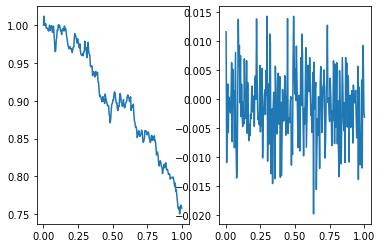

In [3]:
Example_R = stock_sim_stat(1,1/252,-0.3,0.1,0.02,1.,True,10)

## 2.1 The non-stationary Market Case

In [4]:
def stock_sim_nonstat(T,dt,mu0,sigma0,r,delta,gamma,S0,M,plot,seed):
    
    
    # Initial discounted drift
    p0=(mu0-r)/sigma0
    
    # Number of intervals
    N = round(T/dt)
    
    # Grid
    t = np.linspace(0, M*T, M*N)
    
    # Sharpe ratio process
    p = p0+t*delta
    
    # Seed
    np.random.seed(seed)
    
    # Sample and generate standard Brownian motions
    mu = np.array([0,0])
    cov = np.array([[1, gamma] , [gamma , 1]])
    W = np.random.multivariate_normal(mu, cov, size=M*N)
    W1 = np.cumsum(W[:,1])*np.sqrt(dt)
    W1[0]=0
    W2 = np.cumsum(W[:,0])*np.sqrt(dt)
    
    # Volatility process
    X = (delta*0.5)*t + np.sqrt(delta)*W1
    sigma = sigma0*np.exp(X)
    
    # Reshape
    p = p.reshape(-1, N)
    sigma = sigma.reshape(-1, N)
    ind = 0
    # Price processes
    S = np.zeros([M,N])
    S[:,0] = S0
    for i in tqdm(range(0,M)):
        for j in range(1,N):
            X = (p[i,j-1]*sigma[i,j-1]+r-0.5*sigma[i,j-1]**2)*dt + sigma[i,j-1]*(W2[ind + 1]-W2[ind])
            S[i,j] = S[i,j-1]*np.exp(X)
            ind = ind + 1
    # Compute Returns
    R = S[:,1:]/S[:,:-1]-1 
    
    if plot:
        select = np.linspace(0,M,20, dtype = int, endpoint=False)
        plt.plot(S[select,:].T)
    
    return R

100%|██████████| 20000/20000 [00:22<00:00, 880.11it/s]


<IPython.core.display.Javascript object>


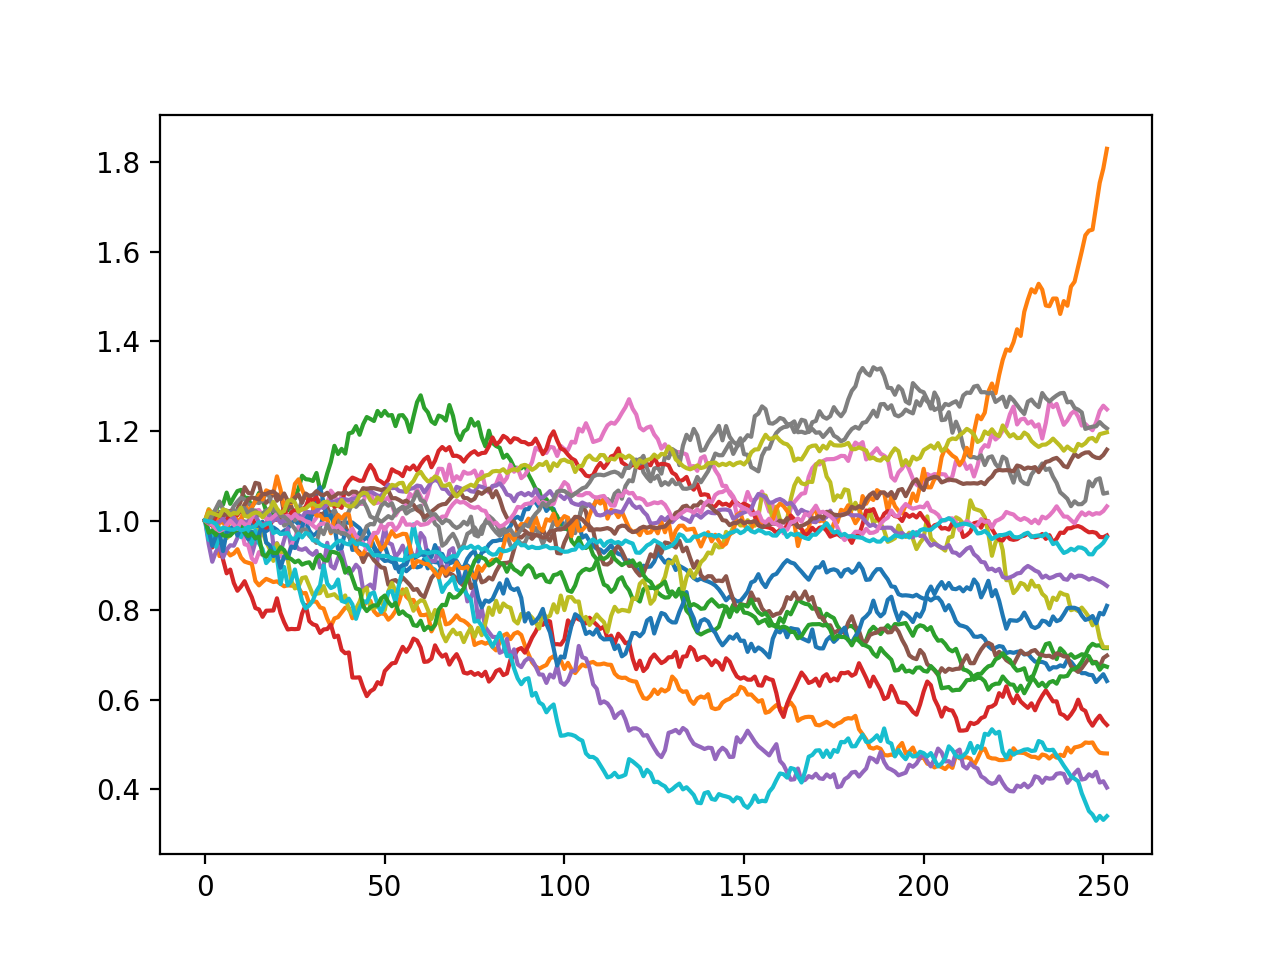

In [5]:
%matplotlib notebook
Returns = stock_sim_nonstat(1,1/252,-0.3,0.2,0.02,0.0001,0,1,20000,True,20)


# 3. The Algorithm

## 3.1 The Cost Function and its Derivatives

In section 5.3.1, we derived the discrteized cost function:

\begin{align}
    C(\theta, \varphi)=\frac{1}{2} \sum_{\left(t_{i}, x_{i}\right) \in \mathcal{D}}\left(\dot{V}^{\theta}\left(t_{i}, x_{i}\right)+\lambda \int_{\mathbb{R}} \pi_{t_{i}}^{\varphi}(u) \ln \pi_{t_{i}}^{\varphi}(u) d u\right)^{2} \Delta t.
\end{align}

Further, we computed its derivatives with respect to the parameters $\theta_1$, $\theta_2$, $\varphi_1$ and $\varphi_2$:

\begin{align}
\begin{split}
\frac{\partial C}{\partial \theta_{1}}&=\sum_{\left(t_{i}, x_{i}\right) \in \mathcal{D}}\left(\dot{V}^{\theta}\left(t_{i}, x_{i}\right)-\lambda\left(\varphi_{1}+\varphi_{2}\left(T-t_{i}\right)\right)\right) \Delta t
\end{split}
\end{align}

\begin{align}
\begin{split}
\frac{\partial C}{\partial \theta_{2}}&=\sum_{\left(t_{i}, x_{i}\right) \in \mathcal{D}}\left(\dot{V}^{\theta}\left(t_{i}, x_{i}\right)-\lambda\left(\varphi_{1}+\varphi_{2}\left(T-t_{i}\right)\right)\right)\left(t_{i+1}^{2}-t_{i}^{2}\right)
\end{split}
\end{align}

In [6]:
def Deriv_Cost_Funct_Theta_1(theta,phi,dt,w,T,D,lam):
    
    ## Input: 
    # theta: Parameter (numpy array with shape (4,1))
    # phi: Parameter (numpy array with shape (2,1))
    # dt: time intervall (float)
    # w: Lagrange multiplier (float)
    # T: terminal time (float or int)
    # D: Set of samples (numpy array with shape (2,k) with k>1)
    # lam: Exploration weight (float or int)
    #
    ## Output: 
    # The derivative of the cost function with respect to theta_1
    
    # Size of set of samples
    n = D.shape[1]
    
    ## Derivative of cost function with respect to theta_1
    
    # Computation of first term by using cancelation
    Term1 = (D[1,-1]-w)**2*np.exp(-theta[3]*(T-D[0,-1]))-(D[1,0]-w)**2*np.exp(-theta[3]*(T-D[0,0]))
    
    # Computation of second term by using formula for partial sum of 1 + 2 + ... + n 
    # and also 1 + 4 + 9 + ... + n^2
    Term2 = theta[2]*dt**2*(n-1)*(n-1)+(n-1)*theta[1]*dt-lam*dt*((n-1)*(phi[0]+phi[1]*T-phi[1]*dt*(n-2)/2))
    
    DCT1 = Term1 + Term2
    
    return DCT1

The next function is not used but stated for completeness.

In [7]:
def Deriv_Cost_Funct_Theta(theta,phi,dt,w,T,D,lam):
    
    ## Input: 
    # theta: Parameter (numpy array with shape (4,1))
    # phi: Parameter (numpy array with shape (2,1))
    # dt: time intervall (float)
    # w: Lagrange multiplier (float)
    # T: terminal time (float or int)
    # D: Set of samples (numpy array with shape (2,k) with k>1)
    # lam: Exploration weight (float or int)
    #
    ## Output: 
    # The derivative of the cost function with respect to theta_1 and theta_2
    
    # Size of set of samples
    n = D.shape[1]
    
    ## Derivative of cost function with respect to theta_1
    DCT1 = Deriv_Cost_Funct_Theta_1(theta,phi,dt,w,T,D,lam)
    
    ## Derivative of cost function with respect to theta_2
    
    # Auxiliary function
    f = lambda x: (x[1]-w)**2*np.exp(-theta[3]*(T-x[0]))
    f_D = f(D)  
    
    # Computation of remaining terms by using formula for partial sum of 1 + 2 + ... + n 
    # and also 1 + 4 + 9 + ... + n^2
    Term1 = 2*(-dt*sum(f_D[1:-1])+(D[1,-1]-w)**2*np.exp(-theta[3]*(T-D[0,-1]))*D[0,-2]) #t0=0
    Term2 = 2*(theta[2]*dt**3*(n-2)*(n-1)*((2*n-3)/3+1/2)+theta[1]*dt**2*(n-2)*(n-1)/2)
    Term3 = -lam*dt**2*(n-2)*(n-1)*(phi[0]+phi[1]*T-phi[1]*dt*(2*n-3)/3)
    
    DCT2 = DCT1*dt + Term1 + Term2 + Term3
    
    return np.array([DCT1,DCT2])


\begin{align}
\begin{split}
\frac{\partial C}{\partial \varphi_{1}}&=-\lambda \sum_{\left(t_{i}, x_{i}\right) \in \mathcal{D}}\left(\dot{V}^{\theta}\left(t_{i}, x_{i}\right)-\lambda\left(\varphi_{1}+\varphi_{2}\left(T-t_{i}\right)\right)\right) \Delta t, \\
\frac{\partial C}{\partial \varphi_{2}}&=\sum_{\left(t_{i}, x_{i}\right) \in \mathcal{D}}\left(\dot{V}^{\theta}\left(t_{i}, x_{i}\right)-\lambda\left(\varphi_{1}+\varphi_{2}\left(T-t_{i}\right)\right)\right) \Delta t\\
&\cdot\bigg(-\frac{2\left(x_{i+1}-w\right)^{2} e^{-2 \varphi_{2}\left(T-t_{i+1}\right)}\left(T-t_{i+1}\right)-2\left(x_{i}-w\right)^{2} e^{-2 \varphi_{2}\left(T-t_{i}\right)}\left(T-t_{i}\right)}{\Delta t}-\lambda\left(T-t_{i}\right)\bigg).
\end{split}
\end{align}

In [8]:
def Deriv_Cost_Funct_Phi(theta,phi,dt,w,T,D,lam):
    
    ## Input: 
    # theta: Parameter (numpy array with shape (4,1))
    # phi: Parameter (numpy array with shape (2,1))
    # dt: time intervall (float)
    # w: Lagrange multiplier (float)
    # T: terminal time (float or int)
    # D: Set of samples (numpy array with shape (2,k) with k>1)
    # lam: Exploration weight (float or int)
    #
    ## Output: 
    # The derivative of the cost function with respect to phi
    
    # Size of set of samples
    n = D.shape[1]
    
    ## Derivative of cost function with respect to theta_1
    DCT1 = Deriv_Cost_Funct_Theta_1(theta,phi,dt,w,T,D,lam)
    
    ## Derivative of cost function with respect to phi_0
    DCP0 = -lam*DCT1
    
    ## Derivative of cost function with respect to phi_1
    
    # Value function
    f_x = lambda x: (x-w)**2
    f1_t = lambda t: np.exp(-theta[3]*(T-t))
    f2_t = lambda t: theta[2]*t**2+theta[1]*t+theta[0]
    
    V = f_x(D[1,:])*f1_t(D[0,:])+f2_t(D[0,:])
    
    # Derivative of value function
    Deriv_V = (V[1:]-V[:-1])/dt
    
    # Differential entropy term
    f3_t = lambda t: -lam*(phi[0]+phi[1]*(T-t))
    
    H = f3_t(D[0,:-1]) 
    
    # First factor
    C1 = (Deriv_V+H)*dt
    
    f2 = lambda x: 2*(x[1]-w)**2*np.exp(-2*phi[1]*(T-x[0]))*(T-x[0])
    f2 = f2(D) 
    
    # Second factor
    C2 = -(f2[1:]-f2[:-1])/dt 
 
    Term1 = -lam*(T+dt/2)*DCT1
    Term2 = np.dot(C1,C2)
    
    DCP1 =  Term1  + Term2
    
    return np.array([DCP0,DCP1])

## 3.2 The EMV Algorithm

In [158]:
def EMV(M,N,eta_phi,eta_theta,alpha,x0,z,w,Returns,theta,phi,dt,T,lam,mu,sigma,r,market):
    
    ## Input: 
    # M: Number of iterations (int>0)
    # N: Sample average size (int>0)
    # eta_phi, eta_theta, alpha: learning rates (float)
    # x0: Initial wealth (float)
    # z: Target payoff (float)
    # w: Lagrange multiplier (float)
    # Returns: Returns of risky asset (numpy array with shape (T/dt,1)) if simulation set to 'simulation' (string)
    # theta: Initail parameter (numpy array with shape (4,1))
    # phi: Initial parameter (numpy array with shape (2,1))
    # dt: time intervall (float>0)
    # T: terminal time (float or int > 0)
    # lam: Exploration weight (float or int)
    # Dec: If True then we have decaying exploration (Bool)   
    #
    ## Output: 
    # mean: The learned mean function of the control process
    # var: The learned variance function of the control process
    # terminal_wealth: The achieved terminal wealth in each iteration
    # var_array: The achieved variance in each iteration
    # SR: The learned Sharpe ratio
    
    ## Set seed
    np.random.seed(10)
    
    ## Initialization
    
    # Initialize arrays to store the terminal wealth and the variance of each iteration  
    terminal_wealth = np.zeros([M])
    estimated_parameters = np.zeros([M])
    portfolio_SR = np.zeros([M])
    
    # Number of time steps
    T1 = int(np.floor(T/dt))
    
    # Initial mean and variance function
    mean_funct = lambda x: -np.sqrt(2*phi[1]/(lam*np.pi))*np.exp((2*phi[0]-1)/2)*(x-w)
    var_funct =  lambda x: 1/(2*np.pi)*np.exp(2*phi[1]*(T-x)+2*phi[0]-1)
    
    # Set of observations/samples
    D = np.zeros([2,T1])
    D[1,0] = np.array(x0)    
    D[0,:] = np.linspace(0,T,T1) 
    
    # Sign
    sign = (mu-r)/abs(mu-r)
    
    ## Iterations
    for k in range(1, M+1):
        
        # Sample Returns
        if market == "stationary":
            R = stock_sim_stat(T,dt,mu,sigma,r,100,False,k**2)
        else:
            R = Returns[k-1,:]
        
        # Determine if price over T increases or decreases to choose sign of mean
        Ret = np.hstack([1,1+R])
        Ret = np.cumprod(Ret) 
        sign = (Ret[-1]-Ret[0])/abs(Ret[-1]-Ret[0])
        
        # Initialization
        x = float(x0)
        
        # Episodes
        for i in range(1, T1):
            
            # Mean and Variance
            variance = var_funct((i-1)*dt)
            mean = mean_funct(x)
            
            # Strategy sample
            u = np.random.normal(loc=mean, scale=variance)
            
            # Compute the wealth at the next time point
            x = x+float(u*R[i-1])    
            x = np.clip(x,x0-1.5*z,x0+1.5*z)
            
            # Update the set of samples
            D[1,i:] = np.array(x)
            
            # Compute the Derivative of the cost function with respect to theta
            Cost_Derivative_theta = Deriv_Cost_Funct_Theta_1(theta,phi,dt,w,T,D[:,:(i+1)],lam)
            
            # Update theta
            theta[1] = theta[1] - eta_theta*Cost_Derivative_theta
            theta[3] = 2*phi[1]
            theta[2] = -lam/2*phi[1]
            theta[0] = -theta[2]*T**2-theta[1]*T-(w-z)**2
        
            # Compute the Derivative of the cost function with respect to phi
            Cost_Derivative_phi = Deriv_Cost_Funct_Phi(theta,phi,dt,w,T,D[:,:(i+1)],lam)
            
            # Update phi
            phi = phi - eta_phi*Cost_Derivative_phi
            
            # Check vaildity of phi
            phi[1] = np.clip(phi[1],0.0000001,100)
               
        # Store terminal wealth and variance of k-th iteration
        terminal_wealth[k-1] = x
        
        # Update Lagrange multiplier
        if k % N == 0:
            w = w - alpha*(1/N*(np.sum(terminal_wealth[(k-N):k]))-z)
            
        # Update control process
        mean_funct = lambda x: -sign*np.sqrt(2*phi[1]/(lam*np.pi))*np.exp((2*phi[0]-1)/2)*(x-w)
        var_funct =  lambda x: 1/(2*np.pi)*np.exp(2*phi[1]*(T-x)+2*phi[0]-1)
        
        # Store learned squared Sharpe ratio
        estimated_parameters[k-1] = theta[3]
        
        # Print current state
        if k % 100 == 0:
            print(str(round(k/M*100,2)) + " %" + "  |  Average Terminal Wealth: " + str(round(np.mean(terminal_wealth[k-100:k]),2)) + "  |  Average Variance: " + str(round(np.var(terminal_wealth[k-100:k]),4))) 
            
    return [[mean_funct,var_funct,terminal_wealth,estimated_parameters]]         
    

# 4. Simulation Study (stationary market case)

## 4.1 Initialization

In [190]:
# Number of iterations
M = 20000
# Sample average size
N = 10
# Exploration weight 
lam = 2
# Time horizon
T = 1.
# Time interval
dt = T/252
# Target 
z = 1.4
# Learning rates
alpha = 0.05
eta_phi = 0.0005
eta_theta = 0.0005
# Initial wealth
x0 = 1.
# Lagrange Multiplier
w = 1.
# Initial paramteres
np.random.seed(1)
phi = np.random.uniform(0,1,2)
theta = np.random.uniform(0,1,4)

# Drift and volatility parameter
mu = 0.3
sigma = 0.2
# Risk-free interest rate
r = 0.02
# Sharpe ratio
rho = (mu-r)/sigma
# market case
market = 'stationary'
Returns = 0



## 4.2 Training

In [191]:
Result = EMV(M,N,eta_phi,eta_theta,alpha,x0,z,w,Returns,theta,phi,dt,T,lam,mu,sigma,r,market)


0.5 %  |  Average Terminal Wealth: 1.01  |  Average Variance: 0.0002
1.0 %  |  Average Terminal Wealth: 1.02  |  Average Variance: 0.0003
1.5 %  |  Average Terminal Wealth: 1.03  |  Average Variance: 0.0005
2.0 %  |  Average Terminal Wealth: 1.04  |  Average Variance: 0.0008
2.5 %  |  Average Terminal Wealth: 1.05  |  Average Variance: 0.0011
3.0 %  |  Average Terminal Wealth: 1.06  |  Average Variance: 0.0016
3.5 %  |  Average Terminal Wealth: 1.07  |  Average Variance: 0.0022
4.0 %  |  Average Terminal Wealth: 1.09  |  Average Variance: 0.0032
4.5 %  |  Average Terminal Wealth: 1.09  |  Average Variance: 0.0044
5.0 %  |  Average Terminal Wealth: 1.12  |  Average Variance: 0.0063
5.5 %  |  Average Terminal Wealth: 1.14  |  Average Variance: 0.0058
6.0 %  |  Average Terminal Wealth: 1.14  |  Average Variance: 0.0081
6.5 %  |  Average Terminal Wealth: 1.16  |  Average Variance: 0.0105
7.0 %  |  Average Terminal Wealth: 1.19  |  Average Variance: 0.0133
7.5 %  |  Average Terminal Wealth:

59.5 %  |  Average Terminal Wealth: 1.41  |  Average Variance: 0.1398
60.0 %  |  Average Terminal Wealth: 1.39  |  Average Variance: 0.1303
60.5 %  |  Average Terminal Wealth: 1.42  |  Average Variance: 0.0859
61.0 %  |  Average Terminal Wealth: 1.4  |  Average Variance: 0.1478
61.5 %  |  Average Terminal Wealth: 1.43  |  Average Variance: 0.1031
62.0 %  |  Average Terminal Wealth: 1.35  |  Average Variance: 0.1018
62.5 %  |  Average Terminal Wealth: 1.38  |  Average Variance: 0.1658
63.0 %  |  Average Terminal Wealth: 1.42  |  Average Variance: 0.1108
63.5 %  |  Average Terminal Wealth: 1.4  |  Average Variance: 0.1057
64.0 %  |  Average Terminal Wealth: 1.44  |  Average Variance: 0.0803
64.5 %  |  Average Terminal Wealth: 1.35  |  Average Variance: 0.1257
65.0 %  |  Average Terminal Wealth: 1.41  |  Average Variance: 0.1175
65.5 %  |  Average Terminal Wealth: 1.38  |  Average Variance: 0.1138
66.0 %  |  Average Terminal Wealth: 1.4  |  Average Variance: 0.0831
66.5 %  |  Average Term

In [192]:
Result[0][3]

array([1.0639221 , 0.84711072, 0.72409676, ..., 3.63873363, 3.91685738,
       3.74454593])

## 4.3 Plots and Results

### 4.3.1 Learning curves of sample means and sample variances of terminal wealth

<IPython.core.display.Javascript object>


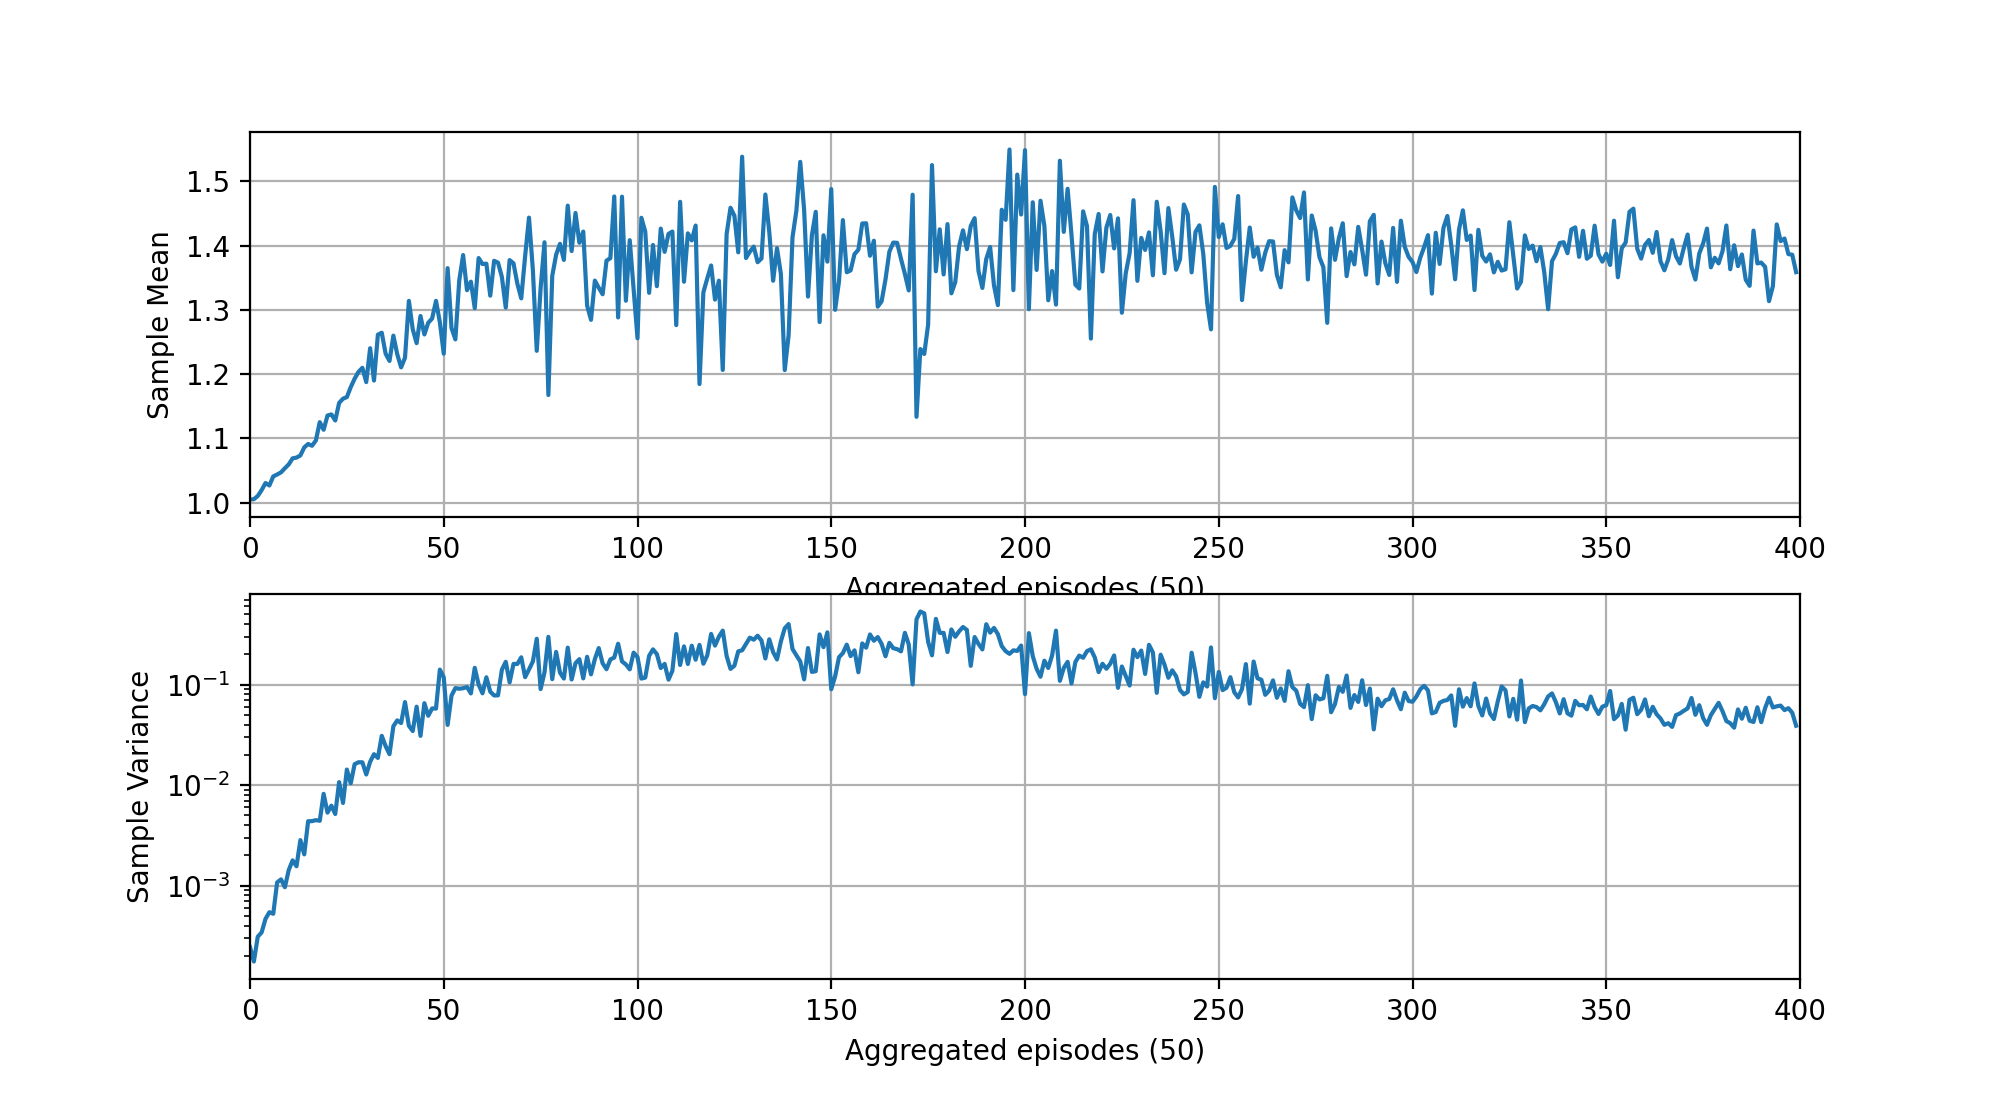

Annualized return: 38.38%
Standard deviation: 23.06%
Sharpe Ratio: 1.58


In [193]:
%matplotlib notebook
# Mean of terminal wealth over 50 iterations
terminal_wealth = Result[0][2]
terminal_wealth_50 = np.mean(terminal_wealth.reshape(-1, 50), axis=1)

# Standard deviation of terminal wealthes over 50 iterations
Std_50 = np.var(terminal_wealth.reshape(-1, 50), axis=1)

##Plots
plt.rcParams["figure.figsize"] = (10,5.5)
# sample means
plt.subplot(2, 1, 1)
plt.plot(terminal_wealth_50)
plt.xlim((0,400))
plt.grid()
plt.xlabel("Aggregated episodes (50)")
plt.ylabel("Sample Mean")
# sample variances
plt.subplot(2, 1, 2)
plt.plot(Std_50)
plt.yscale('log')
plt.xlim((0,400))
plt.grid()
plt.xlabel("Aggregated episodes (50)")
plt.ylabel("Sample Variance")
plt.show()

# Print
ann_return = np.mean(terminal_wealth[-2000:])/x0-1
std_return = np.std(terminal_wealth[-2000:])
print('Annualized return: ' + str(round(ann_return*100,2)) + '%')
print('Standard deviation: ' + str(round(std_return*100,2)) + '%')
print('Sharpe Ratio: ' + str(round((ann_return-r)/std_return,2)))

### 4.3.2 Learned squared Sharpe ratio and ground truth

Relative error: 0.9086


<IPython.core.display.Javascript object>


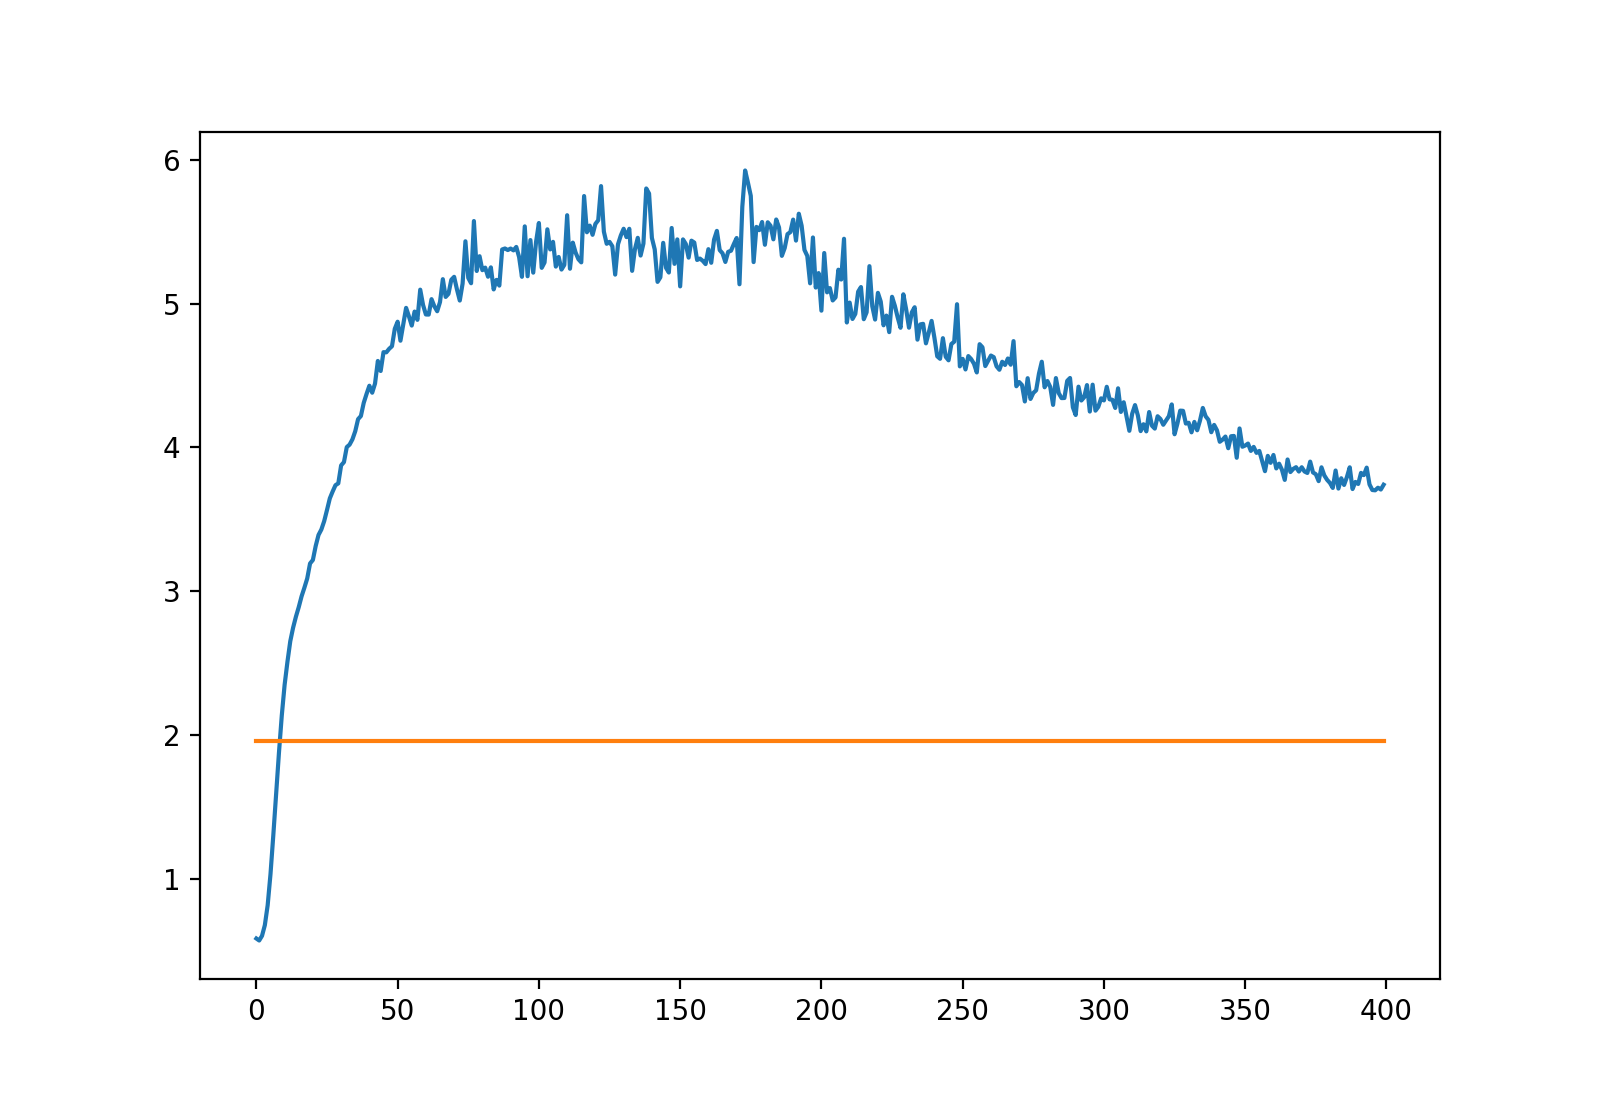

In [194]:
%matplotlib notebook
# Mean of parameters over 50 iterations
est_para = Result[0][3]
SR_sqr = np.mean(est_para.reshape(-1, 50), axis=1)

# Relative error
rel_err = abs(SR_sqr[-1]-rho**2)/rho**2
print('Relative error: ' + str(round(rel_err,4)))

##Plots
plt.rcParams["figure.figsize"] = (8,5.5)
# rho^2
plt.plot(SR_sqr)
plt.plot(np.repeat(rho**2,len(SR_sqr)))

plt.show()

# 5. Simulation Study (non-stationary market case)

## 5.1 Initialization

In [198]:
# Terminal time in years
T = 1
# Time interval
dt = T/252
# Initial drift
mu0 = -0.3
# Initial volatility
sigma0 = 0.2
# Interest rate
r = 0.02
# delta
delta = 0.00001
# gamma
gamma = 0.
# Initial price
S0 = 1
# Sample average size
N = 10
# Number of iterations
M = 20000
# rho 
rho = 0
# Seed
seed = 10
# Target 
z = 1.4
# Learning rates
alpha = 0.05
eta_phi = 0.0005
eta_theta = 0.0005
# Initial wealth
x0 = 1.
# Lagrange Multiplier
w = 1.
# Initial paramteres
np.random.seed(1)
phi = np.random.uniform(0,1,2)
theta = np.random.uniform(0,1,4)
# Market case
market = 'non-stationary'


100%|██████████| 20000/20000 [00:14<00:00, 1339.15it/s]


<IPython.core.display.Javascript object>


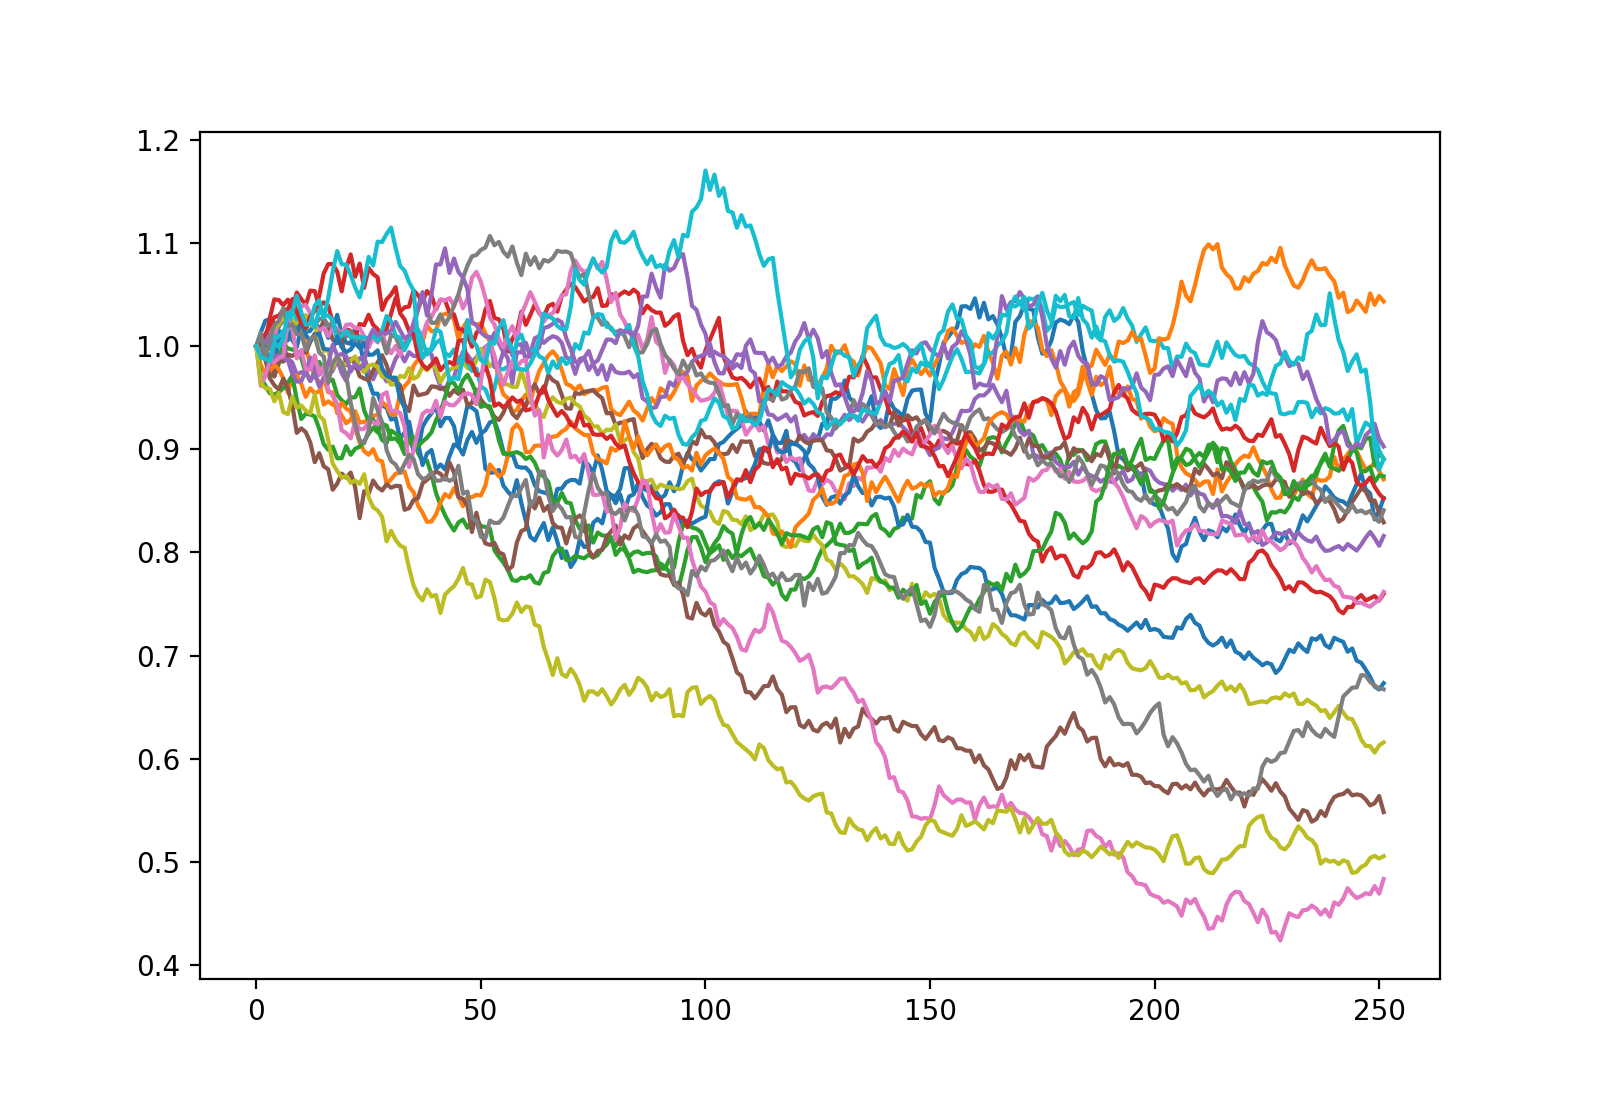

In [199]:
%matplotlib notebook
Returns = stock_sim_nonstat(T,dt,mu0,sigma0,r,delta,gamma,S0,M,True,100)


## 5.2 Training

In [200]:
Result_non_stat = EMV(M,N,eta_phi,eta_theta,alpha,x0,z,w,Returns,theta,phi,dt,T,lam,mu,sigma,r,market)


0.5 %  |  Average Terminal Wealth: 1.0  |  Average Variance: 0.0003
1.0 %  |  Average Terminal Wealth: 1.02  |  Average Variance: 0.0003
1.5 %  |  Average Terminal Wealth: 1.03  |  Average Variance: 0.0004
2.0 %  |  Average Terminal Wealth: 1.04  |  Average Variance: 0.0008
2.5 %  |  Average Terminal Wealth: 1.05  |  Average Variance: 0.0013
3.0 %  |  Average Terminal Wealth: 1.06  |  Average Variance: 0.0014
3.5 %  |  Average Terminal Wealth: 1.08  |  Average Variance: 0.0023
4.0 %  |  Average Terminal Wealth: 1.08  |  Average Variance: 0.0028
4.5 %  |  Average Terminal Wealth: 1.11  |  Average Variance: 0.0044
5.0 %  |  Average Terminal Wealth: 1.12  |  Average Variance: 0.0051
5.5 %  |  Average Terminal Wealth: 1.15  |  Average Variance: 0.006
6.0 %  |  Average Terminal Wealth: 1.15  |  Average Variance: 0.0086
6.5 %  |  Average Terminal Wealth: 1.16  |  Average Variance: 0.0095
7.0 %  |  Average Terminal Wealth: 1.18  |  Average Variance: 0.0117
7.5 %  |  Average Terminal Wealth: 1

59.5 %  |  Average Terminal Wealth: 1.32  |  Average Variance: 0.1771
60.0 %  |  Average Terminal Wealth: 1.44  |  Average Variance: 0.0748
60.5 %  |  Average Terminal Wealth: 1.41  |  Average Variance: 0.1063
61.0 %  |  Average Terminal Wealth: 1.31  |  Average Variance: 0.1126
61.5 %  |  Average Terminal Wealth: 1.36  |  Average Variance: 0.1868
62.0 %  |  Average Terminal Wealth: 1.39  |  Average Variance: 0.1019
62.5 %  |  Average Terminal Wealth: 1.42  |  Average Variance: 0.1135
63.0 %  |  Average Terminal Wealth: 1.42  |  Average Variance: 0.0875
63.5 %  |  Average Terminal Wealth: 1.38  |  Average Variance: 0.1286
64.0 %  |  Average Terminal Wealth: 1.41  |  Average Variance: 0.0913
64.5 %  |  Average Terminal Wealth: 1.36  |  Average Variance: 0.1215
65.0 %  |  Average Terminal Wealth: 1.41  |  Average Variance: 0.0924
65.5 %  |  Average Terminal Wealth: 1.4  |  Average Variance: 0.101
66.0 %  |  Average Terminal Wealth: 1.38  |  Average Variance: 0.1256
66.5 %  |  Average Ter

## 5.3 Plots and Results

### 5.3.1 Learning curves of sample means and sample variances of terminal wealth

<IPython.core.display.Javascript object>


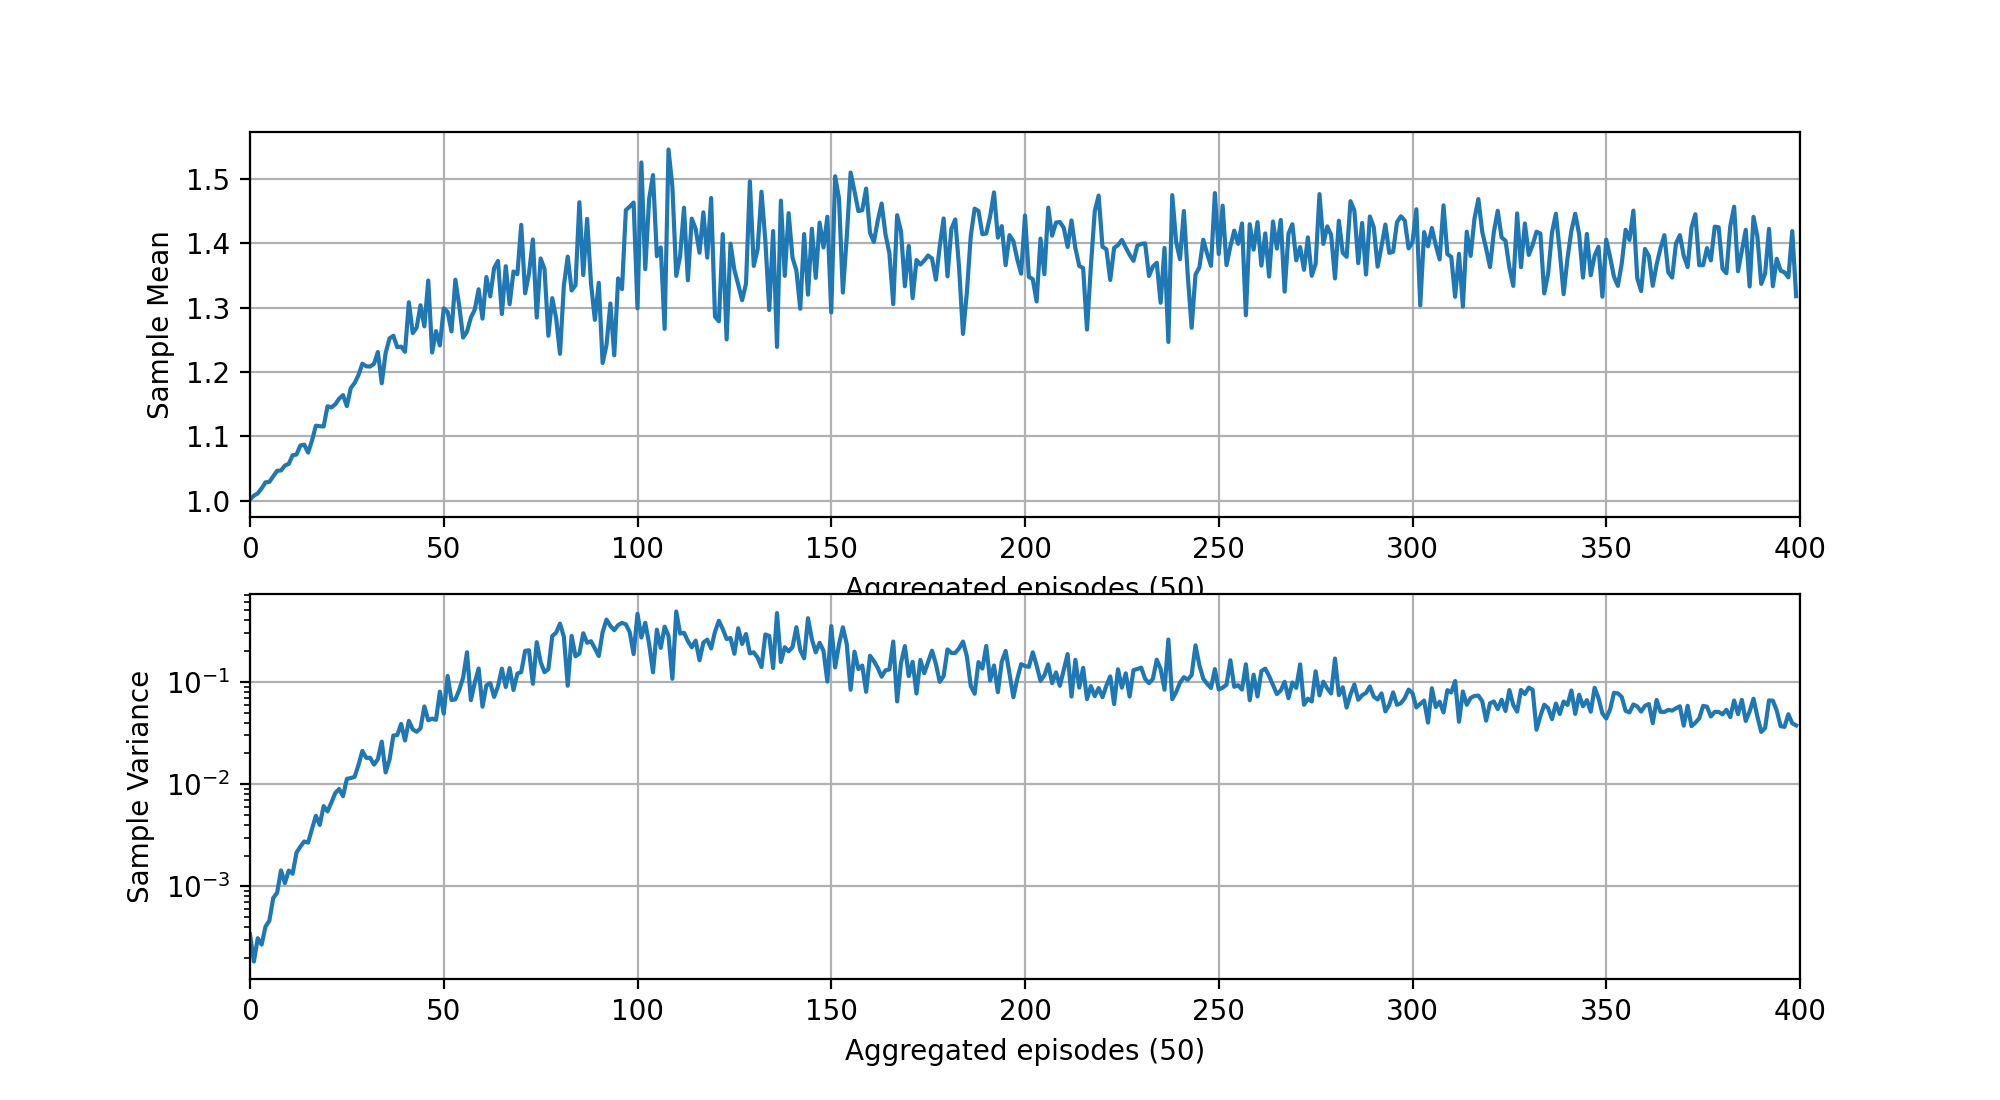

Annualized return: 38.31%
Standard deviation: 22.7%
Sharpe Ratio: 1.6


In [201]:
%matplotlib notebook
# Mean of terminal wealth over 50 iterations
terminal_wealth = Result_non_stat[0][2]
terminal_wealth_50 = np.mean(terminal_wealth.reshape(-1, 50), axis=1)

# Standard deviation of terminal wealthes over 50 iterations
Std_50 = np.var(terminal_wealth.reshape(-1, 50), axis=1)

##Plots
plt.rcParams["figure.figsize"] = (10,5.5)
# sample means
plt.subplot(2, 1, 1)
plt.plot(terminal_wealth_50)
plt.xlim((0,400))
plt.grid()
plt.xlabel("Aggregated episodes (50)")
plt.ylabel("Sample Mean")
# sample variances
plt.subplot(2, 1, 2)
plt.plot(Std_50)
plt.yscale('log')
plt.xlim((0,400))
plt.grid()
plt.xlabel("Aggregated episodes (50)")
plt.ylabel("Sample Variance")
plt.show()

# Print
ann_return = np.mean(terminal_wealth[-2000:])/x0-1
std_return = np.std(terminal_wealth[-2000:])
print('Annualized return: ' + str(round(ann_return*100,2)) + '%')
print('Standard deviation: ' + str(round(std_return*100,2)) + '%')
print('Sharpe Ratio: ' + str(round((ann_return-r)/std_return,2)))